In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Limpieza de los datos



1. Cargar los datos

In [2]:
calificaciones = pd.read_csv("./Datos/calificaciones.csv")
estudiantes = pd.read_csv("./Datos/estudiantes.csv")
carreras = pd.read_csv("./Datos/carrera.csv")
escuelas = pd.read_csv("./Datos/escuelas.csv")

### Primero eliminamos a aquellos estudiantes que su "prepa" no esta registrada como escuela

con esto se quitaron aprox. 2000-3000 filas

In [3]:
ciud = pd.DataFrame(estudiantes["ciudad"].unique(), columns=["ciudad"])
#ciud

In [4]:
#colonias = pd.DataFrame(estudiantes["municipio"].unique(), columns=["municipio"])
#colonias

#municipio_ciudad = estudiantes.groupby('municipio')['ciudad'].unique().reset_index()
#municipio_ciudad.columns = ['municipio', 'ciudades']
#municipio_ciudad

#if estudiantes["municipio"] > 25000 && estudiantes["municipio"] < 25019:
#    estudiantes["ciudad"]


correcta = pd.merge(estudiantes, escuelas[['clave']], left_on='prepa', right_on='clave', how='inner')
#correcta.sort_values('clave_alumno')



### Ahora se filtran todas las calificaciones de alumnos, si la clave del alumno no esta registrada en alumnos se descartan.

In [5]:
correcta2 = pd.merge(calificaciones, estudiantes[['clave_alumno']], left_on='clave_alumno', right_on='clave_alumno', how='inner')
#correcta2.sort_values('clave_alumno')


### aqui filtro a aquellos estudiantes que necesitamos solamente, aquellos que siguen vigentes y que no han terminado sus estudios

In [6]:
correcta3 = estudiantes[(estudiantes['termino'].isnull()) & (estudiantes['causa_salida']==1)]
#correcta3.sort_values('clave_alumno')

In [7]:
nombres_unicos = pd.DataFrame(estudiantes.groupby("municipio")["ciudad"].apply(lambda x: x.unique()))
#nombres_unicos
#nombres_unicos.to_csv('nombres.csv', index=True)


### Aqui ponemos la clave de los municipios correctos, si encuentra otra clave pone por default la de culiacan

In [8]:
#los municipios con clave le asignamos su ciudad correspondiente
correcta3['ciudad'] = correcta3['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else 'Juan Jose Rios' if x == 25020 else 'No encontrado')
#para los municipios que no tienen bien su clave se le asignan por default a culiacan
clave_municipios = [25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020]
clave_cul = 25006
#si no esta en la lista de claves de municipios se le asigna a culiacan
correcta3.loc[~correcta3['municipio'].isin(clave_municipios), 'ciudad'] = 'Culiacan'
#ahora cambiamos los municipios que estan mal a la clave de culiacan
correcta3['municipio'] = correcta3['municipio'].apply(lambda x: clave_cul if x not in clave_municipios else x)

C:\Users\mari_\AppData\Local\Temp\ipykernel_16260\4072386065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correcta3['ciudad'] = correcta3['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else

### Para limpiar los textos que tengan mal el nombre de municipio

In [9]:
from fuzzywuzzy import fuzz

# Función que compara una cadena con "culiacan"
def buscar_culiacan_fuzzy(texto):
    # Asegúrate de que el texto no sea NaN ni nulo antes de aplicar fuzzy matching
    if isinstance(texto, str) and len(texto) > 0:
        if fuzz.ratio(texto.lower(), "culiacan") > 40:  # Umbral de coincidencia
            return 'culiacan'
        elif fuzz.ratio(texto.lower(), "aguaruto") > 40:  # Umbral de coincidencia
            return 'aguaruto'
        elif fuzz.ratio(texto.lower(), "angostura") > 40:  # Umbral de coincidencia
            return 'angostura'
        elif fuzz.ratio(texto.lower(), "bachimeto") > 40:  # Umbral de coincidencia
            return 'bachimeto'
        elif fuzz.ratio(texto.lower(), "concordia") > 40:  # Umbral de coincidencia
            return 'concordia'
        elif fuzz.ratio(texto.lower(), "dorado") > 40:  # Umbral de coincidencia
            return 'el dorado'
        elif fuzz.ratio(texto.lower(), "guamuchil") > 40:  # Umbral de coincidencia
            return 'guamuchil'
        elif fuzz.ratio(texto.lower(), "guasave") > 40:  # Umbral de coincidencia
            return 'guasave'
        elif fuzz.ratio(texto.lower(), "villa juarez") > 40:  # Umbral de coincidencia
            return 'villa juarez'
        elif fuzz.ratio(texto.lower(), "pericos") > 40:  # Umbral de coincidencia
            return 'pericos'
        elif fuzz.ratio(texto.lower(), "salvador alvarado") > 40:  # Umbral de coincidencia
            return 'salvador alvarado'
        elif fuzz.ratio(texto.lower(), "mazatlan") > 40:  # Umbral de coincidencia
            return 'mazatlan'
                   
    return texto

# Aplicar la función a la columna 'ciudad'
df = correcta3
df.loc[:, 'ciudad'] = correcta3['ciudad'].apply(buscar_culiacan_fuzzy)

# Ver el resultado
#correcta3



C:\Users\mari_\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Aqui limpiamos algunas colonias que tienen problemas con el nombre

In [10]:
correcta3['colonia'] = correcta3['colonia'].replace({
    '21': '21 DE MARZO', 
    '21DE': '21 DE MARZO',
    'ADF': 'ADOLFO LOPEZ MATEOS',
    'ADOLFO': 'ADOLFO LOPEZ MATEOS',
    'Adolfo': 'ADOLFO LOPEZ MATEOS',
    'Adolfo Lopez Mateos': 'ADOLFO LOPEZ MATEOS',
    'adolfo': 'ADOLFO LOPEZ MATEOS',
    'AF': 'ADOLFO LOPEZ MATEOS',
    'AGRI.': 'COLONIA AGRICOLA MEXICO',
    'AGRICOLA': 'COLONIA AGRICOLA MEXICO',
    'COL.AGRICOLA': 'COLONIA AGRICOLA MEXICO',
    'COLONIA AGRICOLA M√âXICO': 'COLONIA AGRICOLA MEXICO',
    'COLONIA AGRICOLA M√âXICO': 'COLONIA AGRICOLA MEXICO',
    'col.agricola': 'COLONIA AGRICOLA MEXICO',
    'Colonia Agricola Mexico': 'COLONIA AGRICOLA MEXICO',
    'COL.agricola': 'COLONIA AGRICOLA MEXICO',
    'AGUA': 'AGUACALIENTE',
    'AGUA CALIENTE': 'AGUACALIENTE',
    'ALFONSO': 'ALFONSO G. CALDERON',
    'Alfonso G Calderon': 'ALFONSO G. CALDERON',
    'AMP.TOLEDO': 'AMP. TOLEDO',
    'ALTURAS': 'ALTURAS DEL SUR',
    'AMADO': 'AMADO NERVO',
    'AQUILES': 'AQUILES SERDAN',
    'BALCONES': 'BALCONES DE NUEVO CULIACAN',
    'balcones': 'BALCONES DE NUEVO CULIACAN',
    'Balcones de Nuevo Culiac√°n': 'BALCONES DE NUEVO CULIACAN',
    'BUENOS': 'BUENOS AIRES',
    'Buenos Aires': 'BUENOS AIRES',
    'buenos': 'BUENOS AIRES',
    'BUENA': 'BUENA VISTA',
    'CNOP': 'AMP. CNOP',
    'AMPL.CNOP': 'AMP. CNOP',
    'CU': 'CD. UNIVERSITARIA',
    'C.U': 'CD. UNIVERSITARIA',
    'CIUDADES': 'CIUDADES HERMANAS',
    'CD.': 'CIUDADES HERMANAS',
    'CD. HERMANAS': 'CIUDADES HERMANAS',
    'cd.hermanas': 'CIUDADES HERMANAS',
    'CHULA': 'CHULAVISTA',
    'CHULA VISTA': 'CHULAVISTA',
    'Chula Vista': 'CHULAVISTA',
    'CONOCIDO': 'CONOCIDA',
    'CONOSIDO': 'CONOCIDA',
    'CONOSIDA': 'CONOCIDA',
    'FRAC.NAKAYAMA': 'FRACC. NAKAYAMA',
    'Frac.NAKAYAMA': 'FRACC. NAKAYAMA',
    'fracc.nakayama': 'FRACC. NAKAYAMA',
    'NAKAYAMA': 'FRACC. NAKAYAMA',
    'fracc.zona': 'FRACC. ZONA DORADA',
    'FRAC.': 'FRACC.',
    'FRA': 'FRACC.',
    'FRACC.-': 'FRACC.',
    'EJ.': 'EJIDAL',
    'E.': 'EJIDAL',
    'CANACO': 'FRACC. CANACO',
    'FRACC.CANACO': 'FRACC. CANACO',
    'ESCOBEDO': 'COL. MARIANO ESCOBEDO',
    'ESCOBESO': 'COL. MARIANO ESCOBEDO',
    'FDEL GUTIERREZ': 'FIDEL GUTIERREZ',
    'ZAPATA': 'EMILIANO ZAPATA',
    'zapata': 'EMILIANO ZAPATA',
    'GENARO': 'COL. GENARO ESTRADA',
    'GUADALUPE': 'GUADALUPE VICTORIA',
    'GPE.': 'GUADALUPE VICTORIA',
    'INF.barranacos': 'INFONAVIT BARRANCOS',
    'INF.Barrancos II': 'INFONAVIT BARRANCOS',
    'BARRANCOS': 'INFONAVIT BARRANCOS',
    'JUANDEDIOSBATIZ': 'JUAN DE DIOS BATIZ',
    'rosorio isaraga': 'ROSARIO UZARRAGA',
    'REPUBLICA': 'REPUBLICA MEXICANA',
    'republica': 'REPUBLICA MEXICANA',
    'Ni√±os Heroes': 'NINOS HEROES',
    'Lomalinda': 'LOMA LINDA',
    'LOMALINDA': 'LOMA LINDA',
    'Loma Linda': 'LOMA LINDA',
    'L√ÅZARO': 'LAZARO CARDENAS',
    'Las Ma√±anitas': 'LAS MANANITAS',
    'LAS MA√ëANITAS': 'LAS MANANITAS',
    'LAS MAÑANITAS': 'LAS MANANITAS',
    'LAS Mañanitas': 'LAS MANANITAS',

    'PLUTARCO': 'PLUTARCO ELIAS CALLES',
    'Plutarco Elis Calles': 'PLUTARCO ELIAS CALLES',
    'Priv Lomas del Bosque': 'PRIV. LOMAS DEL BOSQUE'

})

#normalizar las colonias sin acentos con regex y sin simbolos
correcta3['colonia'] = correcta3['colonia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
correcta3 = correcta3[~correcta3['colonia'].isin(['fdgdfg', 'FDSFSSasd', 'INF.LAS','CAITIME'])]

C:\Users\mari_\AppData\Local\Temp\ipykernel_16260\3863108836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correcta3['colonia'] = correcta3['colonia'].replace({
C:\Users\mari_\AppData\Local\Temp\ipykernel_16260\3863108836.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correcta3['colonia'] = correcta3['colonia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


### vuelvo a filtrar solo las calificaciones de los estudisntes que cumplen las condiciones requeridas

In [11]:
correcta4 = pd.merge(calificaciones, correcta3[['clave_alumno']], left_on='clave_alumno', right_on='clave_alumno', how='inner')
correcta4.sort_values('clave_alumno')


correcta3

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida
607,3327,4,1,121,BUENOS AIRES,25006.0,culiacan,2043.0,NaN,1
648,4420,4,1,154,El Walamo,25011.0,guasave,2053.0,NaN,1
662,4434,4,1,127,Alcanfores,25018.0,aguaruto,2053.0,NaN,1
668,4440,4,1,117,Los Angeles,25006.0,culiacan,2053.0,NaN,1
671,4443,4,1,142,NaN,25002.0,angostura,2053.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
11930,11738,8,2,98,Fovissste Playa Azul,25006.0,culiacan,2103.0,NaN,1
11931,11739,8,1,91,LA,25006.0,culiacan,2103.0,NaN,1
11932,11740,8,1,71,BALCONES DE NUEVO CULIACAN,25006.0,culiacan,2103.0,NaN,1
11933,11825,8,1,26,San Miguel,25006.0,culiacan,2103.0,NaN,1


### Eliminamos las colonias que tienen tres o menos caracteres en el dataset

In [12]:
# Eliminar las colonias que tienes 3 o menos caracteres en el dataset
filtro = correcta3['colonia'].dropna().apply(len).between(1, 5)
filtro = filtro.reindex(correcta3.index, fill_value=False)
correcta3 = correcta3[~filtro]
correcta3.reset_index(drop=True, inplace=True)
#correcta3

# pasar todas las colonias a mayusculas
correcta3['colonia'] = correcta3['colonia'].str.upper()

# pasar a csv
#correcta3.to_csv('correcta3.csv', index=False)


C:\Users\mari_\AppData\Local\Temp\ipykernel_16260\2950400143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correcta3['colonia'] = correcta3['colonia'].str.upper()


### Asignamos el nombre de la ciudad o cabecera principal a los municipios con una clave especifica de dicho municipio

In [13]:
#los municipios con clave le asignamos su ciudad correspondiente
correcta3['ciudad'] = correcta3['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else 'Juan Jose Rios' if x == 25020 else 'No encontrado')
#para los municipios que no tienen bien su clave se le asignan por default a culiacan
clave_municipios = [25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020]
clave_cul = 25006
#si no esta en la lista de claves de municipios se le asigna a culiacan
correcta3.loc[~correcta3['municipio'].isin(clave_municipios), 'ciudad'] = 'Culiacan'
#ahora cambiamos los municipios que estan mal a la clave de culiacan
correcta3['municipio'] = correcta3['municipio'].apply(lambda x: clave_cul if x not in clave_municipios else x)

C:\Users\mari_\AppData\Local\Temp\ipykernel_16260\4072386065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correcta3['ciudad'] = correcta3['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else

### Combinamos el excel de carreras con sus respectivos alumnos en correcta3

In [14]:
nuevo = pd.merge(correcta3,carreras,how='inner',on='clave_carrera')
#nuevo.to_csv('nuevo.csv', index=False)

### Agregamos una nueva columna como caracteristica para ver el año que ingreso, y el periodo en el que lo hizo

In [15]:
periodos = {1: "ene-jun", 2: "verano", 3: "ago-dic"}
nuevo['ultimo_digito'] = nuevo['ingreso'] %10
nuevo['periodo'] = nuevo['ultimo_digito'].map(periodos)

nuevo['anio_ingreso'] = nuevo['ingreso'].astype(str).str[1:3]
nuevo['anio_ingreso'] = '20' + nuevo['anio_ingreso']

nuevo['anio_ingreso'] = nuevo['anio_ingreso'].astype(int)

#nuevo.to_csv('nuevo.csv',index=False)

## Preparar el dataset de calificaciones

In [16]:
calificaciones
periodos = {1: "ene-jun", 2: "verano", 3: "ago-dic"}
calificaciones['ultimo_digito'] = calificaciones['periodo'] %10
calificaciones['periodo_act'] = calificaciones['ultimo_digito'].map(periodos)

calificaciones['anio_ingreso_periodo'] = calificaciones['periodo'].astype(str).str[1:3]
calificaciones['anio_ingreso_periodo'] = '20' + calificaciones['anio_ingreso_periodo']

calificaciones['anio_ingreso_periodo'] = calificaciones['anio_ingreso_periodo'].astype(int)

calificaciones

,periodo,clave_alumno,clave_materia,calificacion,tipo_calificacion,ultimo_digito,periodo_act,anio_ingreso_periodo
0,2001,0,ACB9309,100.0,1,1,ene-jun,2000
1,2001,0,ACH9322,75.0,1,1,ene-jun,2000
2,2001,0,ACM9313,0.0,3,1,ene-jun,2000
3,2001,0,ACM9301,0.0,3,1,ene-jun,2000
4,2001,0,ACC9326,93.0,1,1,ene-jun,2000
...,...,...,...,...,...,...,...,...
374721,2103,11853,ACA0907,80.0,1,3,ago-dic,2010
374722,2103,11853,ACC0906,95.0,1,3,ago-dic,2010
374723,2103,11853,ACF0901,95.0,1,3,ago-dic,2010
374724,2103,11853,INC1033,75.0,1,3,ago-dic,2010


### Calcular el promedio de cada estudiante por periodo

In [17]:

promedio = calificaciones.groupby(['clave_alumno','periodo_act','anio_ingreso_periodo'])['calificacion'].mean().reset_index()
promedio = promedio.rename(columns={'calificacion':'promedio'})

dataperiodos = pd.merge(nuevo,promedio,how='inner',on=['clave_alumno'])
#dataperiodos.to_csv('dataperiodos.csv',index=False)
dataperiodos

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida,nombre,corto,ultimo_digito,periodo,anio_ingreso,periodo_act,anio_ingreso_periodo,promedio
0,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2004,68.166667
1,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2005,31.666667
2,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2006,62.000000
3,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2007,80.000000
4,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2008,74.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14404,11737,8,1,153,SAN JOAQUIN,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,ago-dic,2010,85.000000
14405,11738,8,2,98,FOVISSSTE PLAYA AZUL,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,ago-dic,2010,55.333333
14406,11740,8,1,71,BALCONES DE NUEVO CULIACAN,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,ago-dic,2010,54.600000
14407,11825,8,1,26,SAN MIGUEL,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,ago-dic,2010,48.000000


### En base al promedio por periodo de cada alumno sacar su promedio general

In [18]:

promedio_general = promedio.groupby('clave_alumno')['promedio'].mean().reset_index()
promedio_general = promedio_general.rename(columns={'promedio':'promedio_general'})
promedio_general

## a cada estudiante se le asigna su promedio general
nuevo = pd.merge(nuevo,promedio_general,how='inner',on='clave_alumno')
nuevo

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida,nombre,corto,ultimo_digito,periodo,anio_ingreso,promedio_general
0,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,67.450000
1,4420,4,1,154,EL WALAMO,25011.0,Guasave,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,66.660606
2,4434,4,1,127,ALCANFORES,25018.0,Navolato,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,56.950649
3,4440,4,1,117,LOS ANGELES,25006.0,Culiacan,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,60.455952
4,4443,4,1,142,NaN,25002.0,Angostura,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,49.705556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,11737,8,1,153,SAN JOAQUIN,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,85.000000
2842,11738,8,2,98,FOVISSSTE PLAYA AZUL,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,55.333333
2843,11740,8,1,71,BALCONES DE NUEVO CULIACAN,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,54.600000
2844,11825,8,1,26,SAN MIGUEL,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,48.000000


### Creamos el modelo de machine learning

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error

# Convertir promedio_general en clases (0: Sin riesgo, 1: En riesgo)
#umbral = 70  # Define un umbral para considerar en riesgo
#nuevo['riesgo_bajo_rendimiento'] = nuevo['promedio_general'].apply(lambda x: 1 if x < umbral else 0)

#Division de los datos
caracteristicas_nuevo = ['sexo','prepa','colonia','municipio','ciudad','nombre','periodo_act']
X = dataperiodos[caracteristicas_nuevo]
y = dataperiodos['promedio']
# Redefinir la variable objetivo
#y = nuevo['riesgo_bajo_rendimiento']

#Codificar las variables categoricas
X_encoded = pd.get_dummies(X, columns=['sexo','prepa','colonia','municipio','ciudad','nombre','periodo_act'])

#Dvidir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#Entrenamiento del modelo
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

#Prediccion
y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))


11.160334853262928


### Implementar el modelo a los datos

In [25]:
dataperiodos['promedio_delsigperiodo'] = model.predict(X_encoded)

print(dataperiodos['promedio_delsigperiodo'].head())

dataperiodos.to_csv('dataperiodosnuevo.csv',index=False)

0    64.816452
1    64.816452
2    64.816452
3    64.816452
4    64.816452
Name: promedio_delsigperiodo, dtype: float64


### ver el calculo para un estudiante

In [21]:
import matplotlib.pyplot as plt

clave_alumno_ejemplo = 3327
estudiante = dataperiodos[dataperiodos['clave_alumno'] == clave_alumno_ejemplo]
print(estudiante[['periodo_act', 'promedio', 'promedio_delsigperiodo']])

   periodo_act   promedio  promedio_delsigperiodo
0      ago-dic  68.166667               64.816452
1      ago-dic  31.666667               64.816452
2      ago-dic  62.000000               64.816452
3      ago-dic  80.000000               64.816452
4      ago-dic  74.166667               64.816452
5      ago-dic  76.500000               64.816452
6      ene-jun  43.750000               50.500974
7      ene-jun  77.000000               50.500974
8      ene-jun  84.400000               50.500974
9      ene-jun  29.200000               50.500974
10      verano  80.000000               82.582857
11      verano  80.000000               82.582857
12      verano  90.000000               82.582857


### Validamos el desempeño del modelo de aprendizaje

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluación del modelo
mae = mean_absolute_error(dataperiodos['promedio'],dataperiodos['promedio_delsigperiodo'])
mse = mean_squared_error(dataperiodos['promedio'],dataperiodos['promedio_delsigperiodo'])
print(f"MAE: {mae}, MSE: {mse}")
mape = (abs(dataperiodos['promedio'] - dataperiodos['promedio_delsigperiodo']) / dataperiodos['promedio']).mean() * 100
print(f"MAPE: {mape}%")



MAE: 8.089187066030894, MSE: 136.8739576775982
MAPE: inf%


### Hacemos una comparacion para ver si el promedio del sig periodo es similar a los periodos del alumno

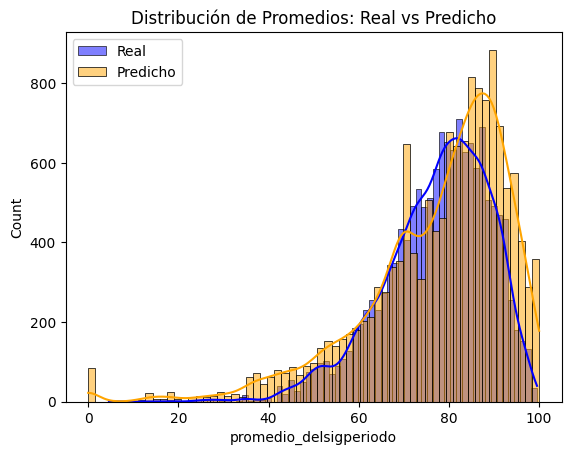

In [23]:
# Comparar distribución entre predicciones y valores reales
import seaborn as sns

sns.histplot(dataperiodos['promedio_delsigperiodo'], label='Real', color='blue', kde=True)
sns.histplot(dataperiodos['promedio'], label='Predicho', color='orange', kde=True)
plt.legend()
plt.title('Distribución de Promedios: Real vs Predicho')
plt.show()

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

